In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn import svm
from empath import Empath
import itertools
import pickle
import spacy

from dataset_prep import dataset

In [2]:
filename = dataset()
data = pd.read_csv(filename)

data.loc[data['Label']== 0, 'Label'] = 'REAL'
data.loc[data['Label']== 1, 'Label'] = 'FAKE'

data.head()

,Headline,Body,Label
0,House narrowly passes measure paving way for T...,WASHINGTON (Reuters) - The U.S. House of Repre...,FAKE
1,Watch This Bundy Militiaman Challenge Chris C...,It s been more than three weeks since a group ...,REAL
2,U.S. Senate approves Chao to lead Transportati...,"WASHINGTON (Reuters) - Elaine Chao, a former t...",FAKE
3,IS A REVOLUTION COMING? Former Congressman Thr...,Spoken like a true American Former Congressman...,REAL
4,WATCH: Trump Gets His Deplorable A** Handed T...,Hillary Clinton was wrong to say that half of ...,REAL


In [3]:
data['Label'].value_counts()

REAL    23481
FAKE    21417
Name: Label, dtype: int64

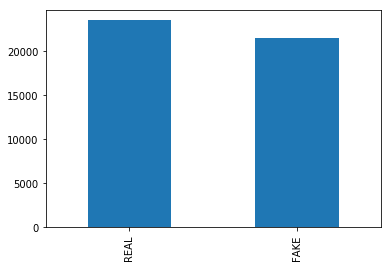

In [4]:
data['Label'].value_counts().plot(kind = 'bar')

## Data Cleaning

In [5]:
data['Text'] = data['Headline'].map(str) + data['Body']

#Drop Duplicates
data.drop_duplicates(subset='Text', inplace=True)

#Convert all to lower case
data['Text'] = data['Text'].str.lower()

#Remove all punctuations
data['Text'] = data['Text'].str.replace('[^\w\s]',' ')

#Remove all digits
data['Text'] = data['Text'].str.replace('[^A-Za-z]',' ')

#Double spaces removed
data['Text'] = data['Text'].str.replace('  ',' ')

y_data = data.Label
y_data = y_data.astype('str')

X_train, X_test, y_train, y_test = train_test_split(data['Text'], y_data, test_size=0.2)

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(31284,) (31284,)
(7821,) (7821,)


In [7]:
X_test[:10]

10224    top democrat activist who launched online camp...
34755    after brexit uk aims for trade deal with eu th...
22307     video trump and o reilly discuss debate admit...
38062     trump lies to his supporters claims cbs edite...
14389     president obama just called trump out for ask...
3217     hillary offended by trump s words caught on ta...
7327     religion of progressivism meet obama s new tra...
16746    high school shows students racist sh t white p...
37972     trump s friend snaps pic with guy holding nuc...
30101    fancy a political revolution  try bernie s yea...
Name: Text, dtype: object

## Vectorization

In [8]:
#Tf-idf Bigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))

TF_IDF_train1 = Tfidf_vectorizer.fit_transform(X_train.astype('str'))
TF_IDF_test1 = Tfidf_vectorizer.transform(X_test.astype('str'))

pickle.dump(TF_IDF_train1, open('TF_IDF_train1.pickle', 'wb'))
pickle.dump(TF_IDF_test1, open('TF_IDF_test1.pickle', 'wb'))

In [9]:
Tfidf_vectorizer.get_feature_names()[-10:]

['zzpx bzka',
 'zzqvyk xif',
 'zzsg pbf',
 'zztaine feminit',
 'zzucqevt mike',
 'zzywyr sean',
 'zzzzaaaacccchhh april',
 'zzzzaaaacccchhh january',
 'zzzzaaaacccchhh march',
 'zzzzzzzz boring']

In [10]:
# Create a Confusion-Matrix
def generate_confusion_matrix(matrix, classes, normalize=False):
    
    plt.imshow(matrix, interpolation='nearest', cmap = plt.cm.Blues)
    plt.title('Confusion-Matrix')
    plt.colorbar()
    
    labels = np.arange(len(classes))
    plt.xticks(labels, classes, rotation=90)
    plt.yticks(labels, classes)
    
    if normalize:
        matrix = matrix.astype('float')/matrix.sum(axis=0)[:, np.newaxis]
        plt.title('Normalized Confusion-Matrix')
    
    thresh = matrix.max()/2
    
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### KNeighbors Classifier

In [11]:
classifier = KNeighborsClassifier()
classifier.fit(TF_IDF_train1, y_train)

pickle.dump(classifier, open('TF_IDF_KN', 'wb'))

pred = classifier.predict(TF_IDF_test1)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with KNeighbors Classifier:   %0.3f" % score)

Accuracy with KNeighbors Classifier:   0.894


              precision    recall  f1-score   support

        FAKE       0.86      0.96      0.91      4254
        REAL       0.95      0.81      0.88      3567

    accuracy                           0.89      7821
   macro avg       0.90      0.89      0.89      7821
weighted avg       0.90      0.89      0.89      7821



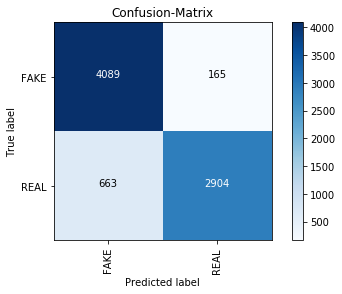

In [12]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

### Multinomial Naive Bayes

In [13]:
classifier = MultinomialNB()
classifier.fit(TF_IDF_train1, y_train)

pickle.dump(classifier, open('TF_IDF_NB', 'wb'))

pred = classifier.predict(TF_IDF_test1)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.945


              precision    recall  f1-score   support

        FAKE       0.91      1.00      0.95      4254
        REAL       0.99      0.88      0.94      3567

    accuracy                           0.94      7821
   macro avg       0.95      0.94      0.94      7821
weighted avg       0.95      0.94      0.94      7821



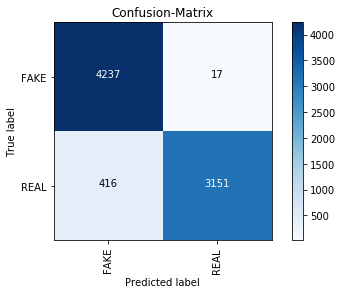

In [14]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

### Logistic Regression Classifier

In [15]:
classifier = LogisticRegression()
classifier.fit(TF_IDF_train1, y_train)

pickle.dump(classifier, open('TF_IDF_LR', 'wb'))

pred = classifier.predict(TF_IDF_test1)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Logistic regression classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with Logistic regression classifier:   0.972


              precision    recall  f1-score   support

        FAKE       0.96      0.99      0.97      4254
        REAL       0.99      0.95      0.97      3567

    accuracy                           0.97      7821
   macro avg       0.97      0.97      0.97      7821
weighted avg       0.97      0.97      0.97      7821



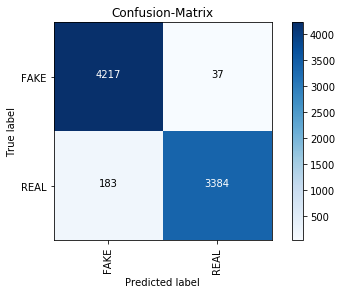

In [16]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

### Random Forest Classifier

In [17]:
classifier = RandomForestClassifier()
classifier.fit(TF_IDF_train1, y_train)

pickle.dump(classifier, open('TF_IDF_RF', 'wb'))

pred = classifier.predict(TF_IDF_test1)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Random Forest Classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy with Random Forest Classifier:   0.941


              precision    recall  f1-score   support

        FAKE       0.92      0.98      0.95      4254
        REAL       0.97      0.90      0.93      3567

    accuracy                           0.94      7821
   macro avg       0.95      0.94      0.94      7821
weighted avg       0.94      0.94      0.94      7821



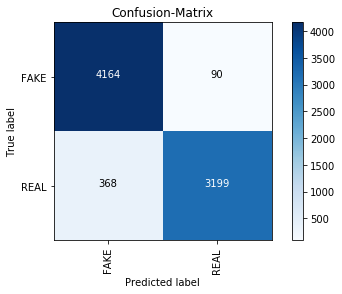

In [18]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

## Adding POS Tags in the dataset

In [19]:
import en_core_web_sm
nlp = en_core_web_sm.load()
x = []

data["Text"] = data["Headline"].map(str) + data["Body"]
for text in data['Text']:
    text_new = []
    doc = nlp(text)
    for token in doc:
        text_new.append(token.pos_)
    txt = ' '.join(text_new)
    x.append(txt)

data['Text_pos'] = x
data.to_pickle('newdata.pkl')

In [20]:
y_data = data.Label
y_data = y_data.astype('str')

X_train, X_test, y_train, y_test = train_test_split(data['Text_pos'], y_data, test_size=0.2)
X_train[:10]

40517    PROPN PROPN VERB PROPN PART VERB NOUN NOUN PUN...
40516    PROPN VERB VERB NOUN ADP ADJ NOUN ADP PROPN PU...
10496    NOUN NOUN PROPN NOUN PUNCT PROPN PROPN PROPN P...
8682     PROPN PART VERB ADP ADJ ADJ NOUN ADP PROPN PUN...
10917    DET ADJ PUNCT NOUN PROPN PROPN PUNCT NOUN VERB...
28809    ADJ NOUN VERB ADP PROPN ADJ NOUN SCONJ PROPN P...
4692     SPACE PROPN PUNCT PROPN PROPN PROPN PROPN ADV ...
29642    SPACE PROPN PROPN PROPN PROPN PROPN PROPN PUNC...
31019    PROPN PROPN PART VERB ADP NOUN NOUN PART NOUN ...
6594     PRON VERB AUX ADP PROPN PART ADJ NOUN NOUN PUN...
Name: Text_pos, dtype: object

In [21]:
#Tf-idf Bigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))

TF_IDF_train2 = Tfidf_vectorizer.fit_transform(X_train.astype('str'))
TF_IDF_test2 = Tfidf_vectorizer.transform(X_test.astype('str'))

pickle.dump(TF_IDF_train2, open('TF_IDF_train2.pickle', 'wb'))
pickle.dump(TF_IDF_test2, open('TF_IDF_test2.pickle', 'wb'))

In [22]:
Tfidf_vectorizer.get_feature_names()[-10:]

['verb intj',
 'verb noun',
 'verb num',
 'verb pron',
 'verb propn',
 'verb punct',
 'verb sconj',
 'verb space',
 'verb sym',
 'verb verb']

In [23]:
classifier = MultinomialNB()
classifier.fit(TF_IDF_train2, y_train)

pickle.dump(classifier, open('POS_NB', 'wb'))

pred = classifier.predict(TF_IDF_test2)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.875


              precision    recall  f1-score   support

        FAKE       0.83      0.97      0.89      4186
        REAL       0.95      0.77      0.85      3635

    accuracy                           0.87      7821
   macro avg       0.89      0.87      0.87      7821
weighted avg       0.89      0.87      0.87      7821



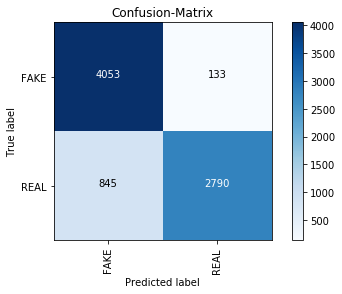

In [24]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

In [25]:
classifier = KNeighborsClassifier()
classifier.fit(TF_IDF_train2, y_train)

pickle.dump(classifier, open('POS_KN', 'wb'))

pred = classifier.predict(TF_IDF_test2)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with KNeighbors Classifier:   %0.3f" % score)

Accuracy with KNeighbors Classifier:   0.914


              precision    recall  f1-score   support

        FAKE       0.88      0.97      0.92      4186
        REAL       0.97      0.84      0.90      3635

    accuracy                           0.91      7821
   macro avg       0.92      0.91      0.91      7821
weighted avg       0.92      0.91      0.91      7821



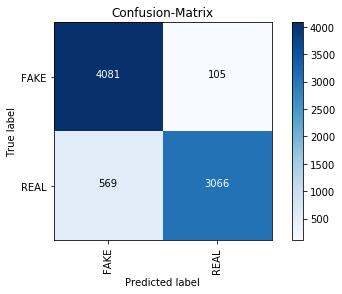

In [26]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

In [27]:
classifier = LogisticRegression()
classifier.fit(TF_IDF_train2, y_train)

pickle.dump(classifier, open('POS_LR', 'wb'))

pred = classifier.predict(TF_IDF_test2)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Logistic regression classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with Logistic regression classifier:   0.955


              precision    recall  f1-score   support

        FAKE       0.94      0.97      0.96      4186
        REAL       0.97      0.93      0.95      3635

    accuracy                           0.95      7821
   macro avg       0.96      0.95      0.95      7821
weighted avg       0.96      0.95      0.95      7821



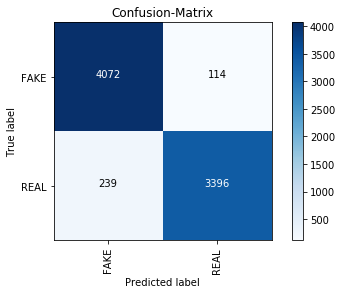

In [28]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

In [29]:
classifier = RandomForestClassifier()
classifier.fit(TF_IDF_train2, y_train)

pickle.dump(classifier, open('POS_RF', 'wb'))

pred = classifier.predict(TF_IDF_test2)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Random Forest Classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy with Random Forest Classifier:   0.948


              precision    recall  f1-score   support

        FAKE       0.93      0.97      0.95      4186
        REAL       0.97      0.92      0.94      3635

    accuracy                           0.95      7821
   macro avg       0.95      0.95      0.95      7821
weighted avg       0.95      0.95      0.95      7821



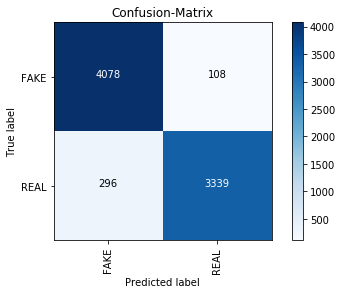

In [30]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

## Using Sentiments to classify Fake News

In [31]:
#Getting the score of semantic categories generated by Empath of each article and generating a tfidf vector.

In [32]:
sentiment = Empath()
semantic = []
count = 0

data['Text'] = data['Headline'].map(str) + data['Body']

for article in data['Text']:
    
    if article == '':
        continue
    
    count += 1
    res = sentiment.analyze(article, normalize=False)
    arr = []
    for key, value in res.items():
        arr.append(value)
    
    arr = np.array(arr)
    semantic.append(arr)

data['Semantics'] = semantic

In [33]:
semantic[0]

array([ 1.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  2.,
        1.,  1.,  4.,  0.,  0.,  1.,  3.,  2.,  0.,  3.,  2.,  0.,  0.,
        1.,  1.,  0.,  6.,  0.,  0.,  0.,  1.,  2.,  0.,  0., 25.,  0.,
        0.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  1., 13.,
        3.,  5.,  0.,  1.,  0.,  1.,  6.,  1.,  0.,  0.,  1.,  1.,  0.,
        0.,  1.,  0.,  1.,  1.,  5.,  2.,  0.,  0.,  0.,  0.,  0.,  3.,
        0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  7.,
       24.,  0.,  0.,  0., 30.,  2.,  1.,  3.,  3., 31.,  0.,  8.,  0.,
        1.,  1.,  4.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  3.,  0.,  1.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  1.,  3.,  1.,  4.,  0.,  5.,  0.,  0.,  3.,
        1.,  1.,  2.,  0., 24.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  4.,
        0.,  4.,  0.,  7.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  5

In [34]:
categories = []
a = sentiment.analyze("")
for key, value in a.items():
    categories.append(key)
categories

['internet',
 'disgust',
 'medical_emergency',
 'fire',
 'kill',
 'ugliness',
 'writing',
 'air_travel',
 'cooking',
 'philosophy',
 'disappointment',
 'ancient',
 'attractive',
 'prison',
 'traveling',
 'gain',
 'divine',
 'exercise',
 'social_media',
 'communication',
 'pain',
 'order',
 'trust',
 'clothing',
 'neglect',
 'beauty',
 'fabric',
 'love',
 'weather',
 'poor',
 'youth',
 'alcohol',
 'sound',
 'science',
 'power',
 'swearing_terms',
 'crime',
 'real_estate',
 'hygiene',
 'masculine',
 'war',
 'fun',
 'cheerfulness',
 'dominant_personality',
 'car',
 'lust',
 'surprise',
 'confusion',
 'terrorism',
 'furniture',
 'hiking',
 'dance',
 'restaurant',
 'sympathy',
 'nervousness',
 'shopping',
 'torment',
 'vehicle',
 'shame',
 'feminine',
 'giving',
 'water',
 'sports',
 'white_collar_job',
 'business',
 'vacation',
 'party',
 'royalty',
 'help',
 'sadness',
 'optimism',
 'achievement',
 'school',
 'reading',
 'anticipation',
 'appearance',
 'driving',
 'worship',
 'animal',
 '

In [35]:
len(categories)

194

In [36]:
sem = []

for i in range(data.shape[0]):
    
    a = []
    for j in range(len(semantic[0])):
        for k in range(int(semantic[i][j])):     ## each semantic of every word in every article
            a.append(categories[j])
        
    b = " ".join(a)
    sem.append(b)

data['Sentiments'] = sem
data.to_pickle('Sentiments.pkl')

In [37]:
sem[0]

'internet disgust kill writing writing disappointment attractive attractive prison traveling gain gain gain gain social_media communication communication communication pain pain trust trust trust clothing clothing fabric love poor poor poor poor poor poor science power power real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate real_estate fun fun fun dominant_personality shopping shopping shopping shopping shopping giving giving giving giving giving white_collar_job business business business business business business business business business business business business business vacation vacation vacation party party party party party help optimism achievement achievement achievement achievement achievement achievement school appearance driving play ind

In [38]:
df = pd.read_pickle('Sentiments.pkl')
print(df.columns)
print(df.shape)

Index(['Headline', 'Body', 'Label', 'Text', 'Text_pos', 'Semantics',
       'Sentiments'],
      dtype='object')
(39105, 7)


In [39]:
y_data = df.Label
y_data = y_data.astype('str')
X_train, X_test, y_train, y_test = train_test_split(df['Semantics'], y_data, test_size=0.33)

In [40]:
X_train

16948    [1.0, 1.0, 9.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, ...
9725     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
7820     [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
30890    [1.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 1.0, 0.0, ...
1707     [1.0, 0.0, 1.0, 3.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...
41495    [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
32417    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
21573    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
36101    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
24352    [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 3.0, 0.0, ...
7187     [5.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
35422    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
22496    [3.0, 1.0, 1.0, 0.0, 1.0, 0.0, 3.0, 0.0, 1.0, ...
16031    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
40171    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, ...
2577     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
583      [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, .

In [41]:
#Tf-idf Unigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1))

TF_IDF_train3 = Tfidf_vectorizer.fit_transform(X_train.astype('str'))
TF_IDF_test3 = Tfidf_vectorizer.transform(X_test.astype('str'))

pickle.dump(TF_IDF_train3, open('TF_IDF_train3.pickle', 'wb'))
pickle.dump(TF_IDF_test3, open('TF_IDF_test3.pickle', 'wb'))

In [42]:
Tfidf_vectorizer.get_feature_names()[-10:]

['81', '82', '83', '84', '86', '87', '88', '93', '94', '96']

In [43]:
# NO NEED TO USE VECTORIZATION ON SENTIMENTS AS THEY HAVE ALREADY BEEN VECTORIZED IN WORD EMBEDDINGS OF SEMANTICS

classifier = MultinomialNB()
classifier.fit(X_train.to_list(), y_train)

pickle.dump(classifier, open('SENT_NB', 'wb'))

pred = classifier.predict(X_test.to_list())
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.777


              precision    recall  f1-score   support

        FAKE       0.79      0.79      0.79      6931
        REAL       0.76      0.76      0.76      5974

    accuracy                           0.78     12905
   macro avg       0.78      0.78      0.78     12905
weighted avg       0.78      0.78      0.78     12905



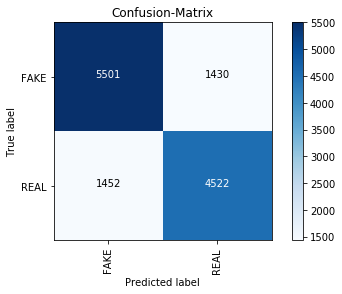

In [44]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

In [45]:
classifier = KNeighborsClassifier()
classifier.fit(X_train.to_list(), y_train)

pickle.dump(classifier, open('SENT_KN', 'wb'))

pred = classifier.predict(X_test.to_list())
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with KNeighbors Classifier:   %0.3f" % score)

Accuracy with KNeighbors Classifier:   0.772


              precision    recall  f1-score   support

        FAKE       0.74      0.88      0.81      6931
        REAL       0.82      0.65      0.72      5974

    accuracy                           0.77     12905
   macro avg       0.78      0.76      0.76     12905
weighted avg       0.78      0.77      0.77     12905



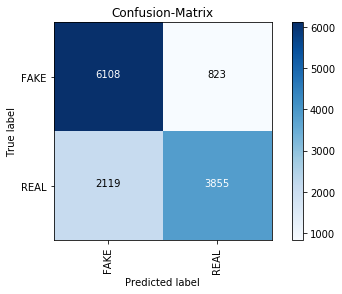

In [46]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

In [47]:
classifier = LogisticRegression()
classifier.fit(X_train.to_list(), y_train)

pickle.dump(classifier, open('SENT_LR', 'wb'))

pred = classifier.predict(X_test.to_list())
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Logistic regression classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with Logistic regression classifier:   0.828


              precision    recall  f1-score   support

        FAKE       0.82      0.88      0.85      6931
        REAL       0.85      0.77      0.81      5974

    accuracy                           0.83     12905
   macro avg       0.83      0.82      0.83     12905
weighted avg       0.83      0.83      0.83     12905



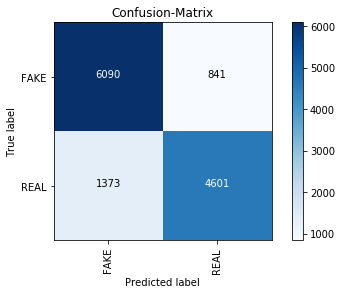

In [48]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

In [49]:
classifier = RandomForestClassifier()
classifier.fit(X_train.to_list(), y_train)

pickle.dump(classifier, open('SENT_RF', 'wb'))

pred = classifier.predict(X_test.to_list())
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Random Forest Classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy with Random Forest Classifier:   0.810


              precision    recall  f1-score   support

        FAKE       0.78      0.90      0.83      6931
        REAL       0.85      0.71      0.78      5974

    accuracy                           0.81     12905
   macro avg       0.82      0.80      0.81     12905
weighted avg       0.82      0.81      0.81     12905



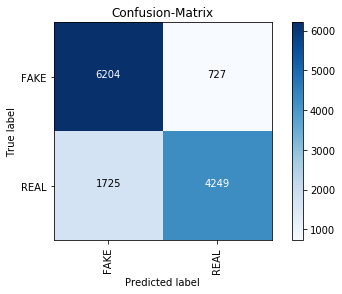

In [50]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

## Combining these 3 parameters to build a final model

In [51]:
data = pd.read_pickle('Sentiments.pkl')
print(data.columns)
print(data.shape)

Index(['Headline', 'Body', 'Label', 'Text', 'Text_pos', 'Semantics',
       'Sentiments'],
      dtype='object')
(39105, 7)


In [52]:
y_data = data.Label
X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.33)

In [53]:
X_train_text = X_train['Text']
X_test_text = X_test['Text']

X_train_text_pos = X_train['Text_pos']
X_test_text_pos = X_test['Text_pos']

X_train_semantics = X_train['Semantics']
X_test_semantics = X_test['Semantics']

In [54]:
#Tf-idf Bigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))

TF_IDF_train1 = Tfidf_vectorizer.fit_transform(X_train_text.astype('str'))
TF_IDF_test1 = Tfidf_vectorizer.transform(X_test_text.astype('str'))

pickle.dump(TF_IDF_train1, open('TF_IDF_train1.pickle', 'wb'))
pickle.dump(TF_IDF_test1, open('TF_IDF_test1.pickle', 'wb'))

In [55]:
#Tf-idf Bigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))

TF_IDF_train2 = Tfidf_vectorizer.fit_transform(X_train_text_pos.astype('str'))
TF_IDF_test2 = Tfidf_vectorizer.transform(X_test_text_pos.astype('str'))

pickle.dump(TF_IDF_train2, open('TF_IDF_train2.pickle', 'wb'))
pickle.dump(TF_IDF_test2, open('TF_IDF_test2.pickle', 'wb'))

In [56]:
#Tf-idf Unigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1))

TF_IDF_train3 = Tfidf_vectorizer.fit_transform(X_train_semantics.astype('str'))
TF_IDF_test3 = Tfidf_vectorizer.transform(X_test_semantics.astype('str'))

pickle.dump(TF_IDF_train3, open('TF_IDF_train3.pickle', 'wb'))
pickle.dump(TF_IDF_test3, open('TF_IDF_test3.pickle', 'wb'))

In [57]:
# The three vector features

train1 = TF_IDF_train1
test1 = TF_IDF_test1

train2 = TF_IDF_train2
test2 = TF_IDF_test2

train3 = TF_IDF_train3
test3 = TF_IDF_test3

In [58]:
#Giving weights to each of the 3 feature vectors generated

big_w = 0.35
synt_w = 0.5
sem_w = 0.15
big_w *= 3
synt_w *= 3
sem_w *= 3

TF_IDF_train1 = big_w*train1
TF_IDF_test1 = big_w*test1

TF_IDF_train2 = synt_w*train2
TF_IDF_test2 = synt_w*test2

TF_IDF_train3 = sem_w*train3
TF_IDF_test3 = sem_w*test3

In [59]:
import scipy.sparse as sp

diff_n_rows = TF_IDF_train2.shape[0] - TF_IDF_train1.shape[0]

Xb_new = sp.vstack((TF_IDF_train1, sp.csr_matrix((diff_n_rows, TF_IDF_train1.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

c = sp.hstack((TF_IDF_train2, Xb_new))

diff_n_rows = c.shape[0] - TF_IDF_train3.shape[0]

Xb_new = sp.vstack((TF_IDF_train3, sp.csr_matrix((diff_n_rows, TF_IDF_train3.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

X = sp.hstack((c, Xb_new))
X

dif_n_rows = TF_IDF_test2.shape[0] - TF_IDF_test1.shape[0]

Xb_ne = sp.vstack((TF_IDF_test1, sp.csr_matrix((dif_n_rows, TF_IDF_test1.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

d = sp.hstack((TF_IDF_test2, Xb_ne))

dif_n_rows = d.shape[0] - TF_IDF_test3.shape[0]

Xb_ne = sp.vstack((TF_IDF_test3, sp.csr_matrix((dif_n_rows, TF_IDF_test3.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

Y = sp.hstack((d, Xb_ne))

In [60]:
classifier = KNeighborsClassifier()
classifier.fit(X, y_train)

pickle.dump(classifier, open('Bi_POS_SENT_KN', 'wb'))

pred = classifier.predict(Y)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with KNeighbors Classifier:   %0.3f" % score)

Accuracy with KNeighbors Classifier:   0.913


              precision    recall  f1-score   support

        FAKE       0.87      0.99      0.93      7016
        REAL       0.99      0.82      0.90      5889

    accuracy                           0.91     12905
   macro avg       0.93      0.91      0.91     12905
weighted avg       0.92      0.91      0.91     12905



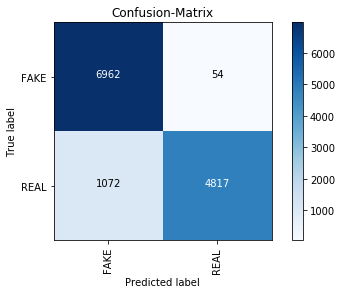

In [61]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

In [62]:
classifier = MultinomialNB()
classifier.fit(X, y_train)

pickle.dump(classifier, open('Bi_POS_SENT_NB', 'wb'))

pred = classifier.predict(Y)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.916


              precision    recall  f1-score   support

        FAKE       0.87      1.00      0.93      7016
        REAL       1.00      0.82      0.90      5889

    accuracy                           0.92     12905
   macro avg       0.93      0.91      0.91     12905
weighted avg       0.93      0.92      0.92     12905



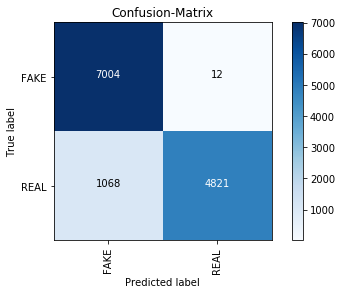

In [63]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

In [64]:
classifier = LogisticRegression()
classifier.fit(X, y_train)

pickle.dump(classifier, open('Bi_POS_SENT_LR', 'wb'))

pred = classifier.predict(Y)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Logistic regression classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with Logistic regression classifier:   0.969


              precision    recall  f1-score   support

        FAKE       0.96      0.98      0.97      7016
        REAL       0.98      0.95      0.97      5889

    accuracy                           0.97     12905
   macro avg       0.97      0.97      0.97     12905
weighted avg       0.97      0.97      0.97     12905



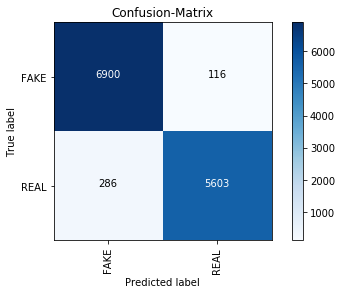

In [65]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))

In [66]:
classifier = RandomForestClassifier()
classifier.fit(X, y_train)

pickle.dump(classifier, open('Bi_POS_SENT_RF', 'wb'))

pred = classifier.predict(Y)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Random Forest Classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy with Random Forest Classifier:   0.914


              precision    recall  f1-score   support

        FAKE       0.88      0.97      0.92      7016
        REAL       0.96      0.84      0.90      5889

    accuracy                           0.91     12905
   macro avg       0.92      0.91      0.91     12905
weighted avg       0.92      0.91      0.91     12905



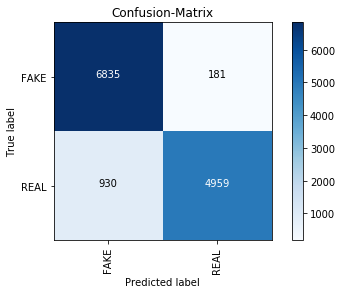

In [67]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

print(metrics.classification_report(y_test, pred, target_names=['FAKE', 'REAL']))